## The data story:
We are given a simple table with data that includes login times over a 4 month period from January-April.

We want to identify what the best time for our company to schedule a 1 hour monthly maintenance check on the badge scan system would be.

Things to identify:
1. Identify login patterns throughout the month and the week.
2. Find optimal 1 hour period to perform a maintenance check on the scan system.
    - **Employees need verification to enter the manufacturing site, otherwise they will not be able to work. The badge scan system is the only verification set in place at this time, therefore the system cannot be under maintenance during high volume times.**
    
---

Load in the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_json('logins.json')

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [8]:
df.shape

(93142, 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
print(df.isnull().sum())

login_time    0
dtype: int64


In [11]:
# create a variable to keep a count of number of logins
df['login_count'] = 1
# reset index to be the datetime object so that we can resample
df15 = df.set_index('login_time').resample('15min').count()
df15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [12]:
df15.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


## We are going to add features to our dataframe so that we can look at some specifics like:
- Day of week
- Month

In [13]:
df15['minute_of_day'] = df15.index.map(lambda x: (x.hour * 60) + x.minute)
df15['day_of_week'] = df15.index.day_name()
df15['date'] = df15.index.date
df15['month'] = df15.index.month_name()
df15.head()

,login_count,minute_of_day,day_of_week,date,month
login_time,,,,,
1970-01-01 20:00:00,2,1200,Thursday,1970-01-01,January
1970-01-01 20:15:00,6,1215,Thursday,1970-01-01,January
1970-01-01 20:30:00,9,1230,Thursday,1970-01-01,January
1970-01-01 20:45:00,7,1245,Thursday,1970-01-01,January
1970-01-01 21:00:00,1,1260,Thursday,1970-01-01,January


# Lets look at the count flow throughout the months and see if anything stands out

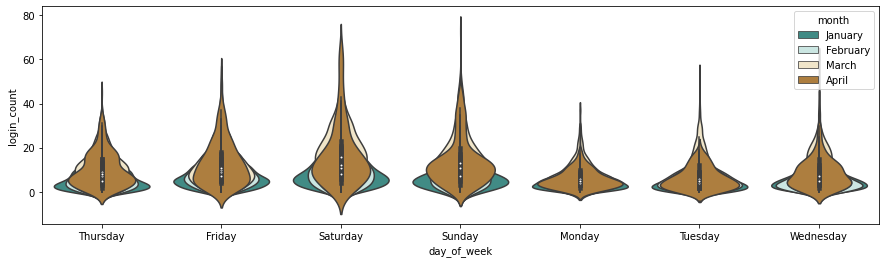

In [19]:
plt.figure(figsize=(15,4))
_=sns.violinplot(x='day_of_week', y='login_count', data=df15, hue='month', dodge=False, palette='BrBG_r')

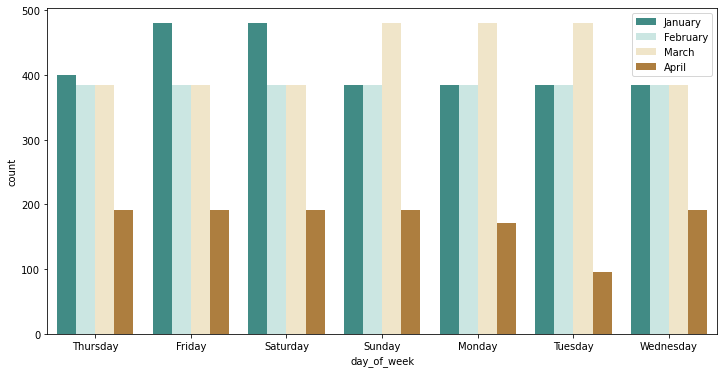

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='day_of_week', data=df15, hue='month', dodge=True, palette='BrBG_r')
_=plt.legend(loc='best')

### Count brief:
- The weekend days tend to have bigger spikes of logins throughout the days (this is because of our surge in the 0 hour, and more stable flow throughout the noon hour)
- In the month of January there was a higher login count on Thursday-Saturday. This is compared to the month of March where there were more logins from Sunday-Tuesday.
- February has a consistent count throughout the week days.
- There isn't sufficient data for April which is why the lower count.

## By day of week

In [14]:
# check work days in the dataframe
df15.day_of_week.unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

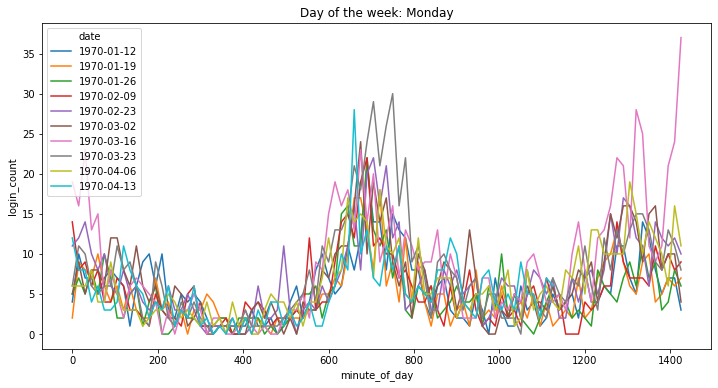

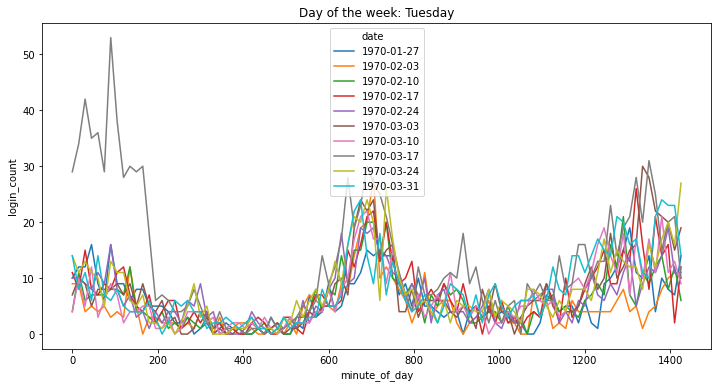

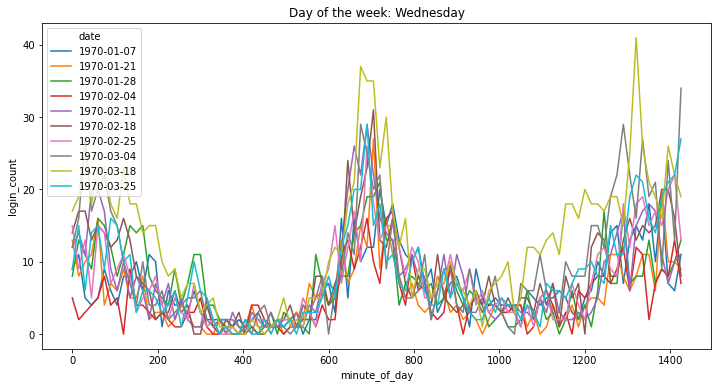

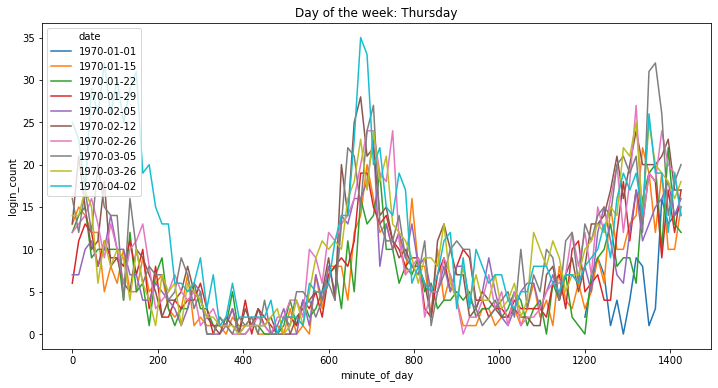

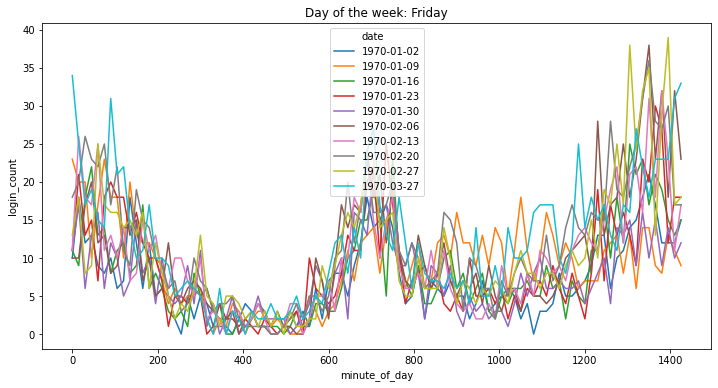

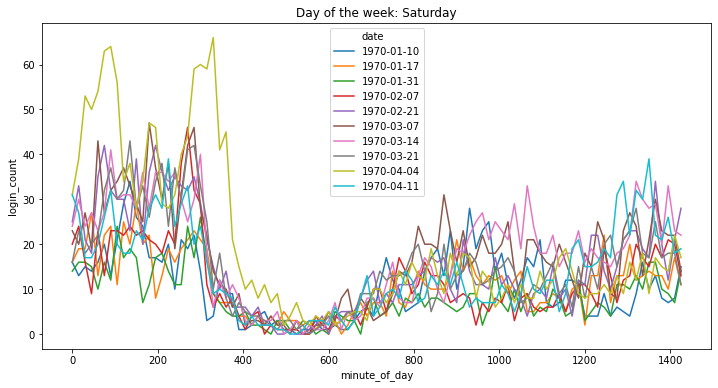

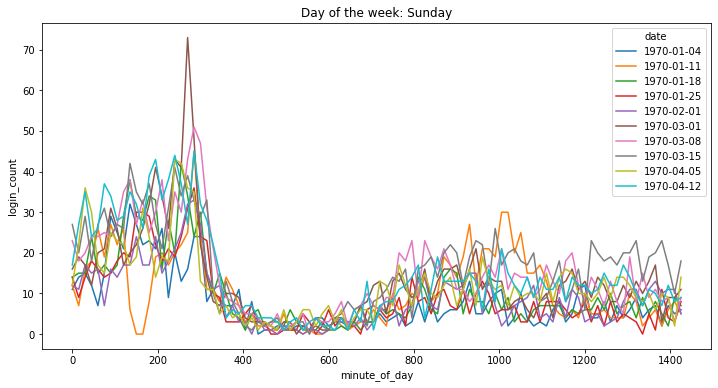

In [15]:
import random

# order weekdays starting with Monday
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    # create dataframe with only one type of day
    df_DOW = df15[df15['day_of_week']==day].copy()
    # iterate over 5 randowm days
    plt.figure(figsize=(12,6))
    usedays = []
    for n in range(10):
        while True:
            pick = random.choice(list(df_DOW['date'].unique()))
            if pick not in usedays:
                usedays.append(pick)
                break
    dfplot = df_DOW.where(df_DOW['date'].isin(usedays)).dropna()
    sns.lineplot(x='minute_of_day', y='login_count', hue='date', data=dfplot)
    plt.title('Day of the week: %s' % day)

## By month
We will exclude weekend days since we can see the hours are very different.

In [16]:
df15.head()

,login_count,minute_of_day,day_of_week,date,month
login_time,,,,,
1970-01-01 20:00:00,2,1200,Thursday,1970-01-01,January
1970-01-01 20:15:00,6,1215,Thursday,1970-01-01,January
1970-01-01 20:30:00,9,1230,Thursday,1970-01-01,January
1970-01-01 20:45:00,7,1245,Thursday,1970-01-01,January
1970-01-01 21:00:00,1,1260,Thursday,1970-01-01,January


In [17]:
df15.month.unique()

array(['January', 'February', 'March', 'April'], dtype=object)

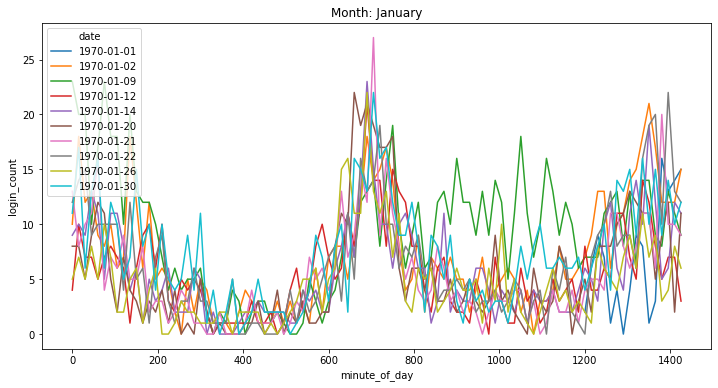

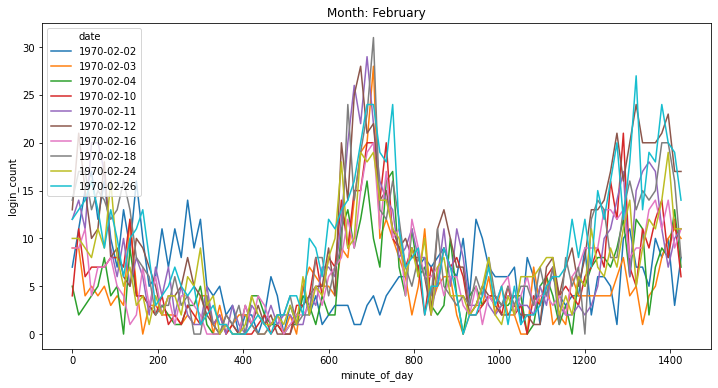

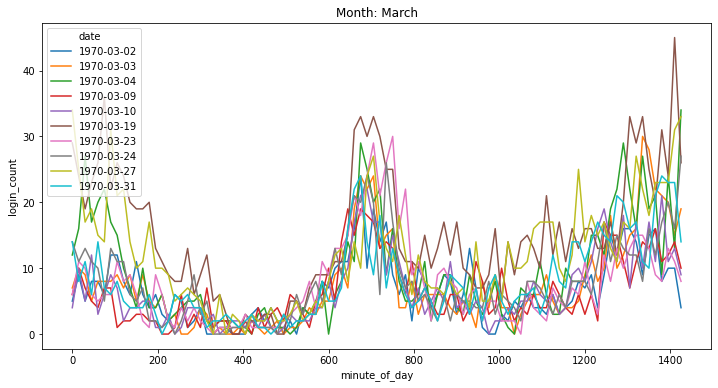

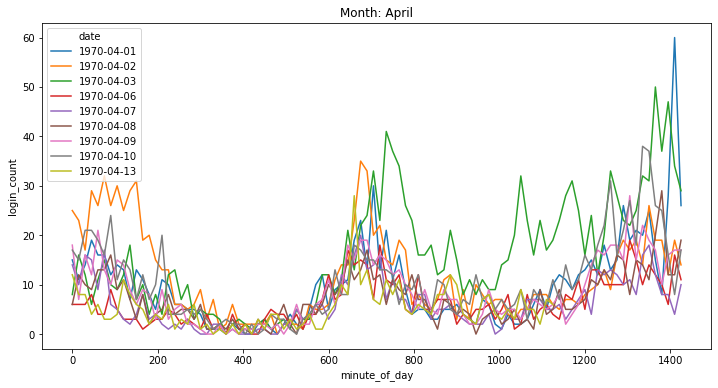

In [18]:
import random

for month in list(df15.month.unique()):
    # create dataframe with only one type of day
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    df_month = df15[(df15['month']==month) & (df15['day_of_week'].isin(days))].copy()
    # iterate over 5 randowm days
    plt.figure(figsize=(12,6))
    use = []
    for n in range(min(10, len(list(df_month['date'].unique())))):
        while True:
            pick = random.choice(list(df_month['date'].unique()))
            if pick not in use:
                use.append(pick)
                break
    dfplot = df_month.where(df_month['date'].isin(use)).dropna()
    sns.lineplot(x='minute_of_day', y='login_count', hue='date', data=dfplot)
    plt.title('Month: %s' % month)

### Day brief:
- It looks like there is a very consistent pattern throughout the common work week.
    - There are 2 periods where employees tend to enter the facility the most - on the 0 and 12 hour mark.
    - Other than a few spikes from the random samples that we took, the login count seems to follow the same pattern daily for our data. This could be caused by data quality issues which we would be able to remove with outlier or anomaly filtering.
- Weekends are the only exception to this pattern. It looks like there is only 1 major period where employees enter, but this period is more than a 3 hour time slot.

### Month brief:
- Typical work-week logins have a very stable pattern - roughly 2 main login periods throughout the day (on hour 0 and 12)
    - Chart shows 3 periods, but the first and last are on roughly the same hour
    - Other than a few spikes from the random samples that we took, the login count seems to follow the same pattern daily for our data. This could be caused by data quality issues which we would be able to remove with outlier or anomaly filtering.

### Conclusion:
- As of now, our best opportunity to perform the maintenance would be on Sunday after the initial surge of employees. This period seems to have the most stable flat-line period
    - The majority of employees have already entered the facilities as well.

**Recommendations:**
- The time slot identified as optimal is on the 2nd Sunday of every month, from 7AM - 8AM.
    - The reasons being the majority of employees have already entered the facility, and it has the lowest frequency of logins during this period.

## Happy Endings

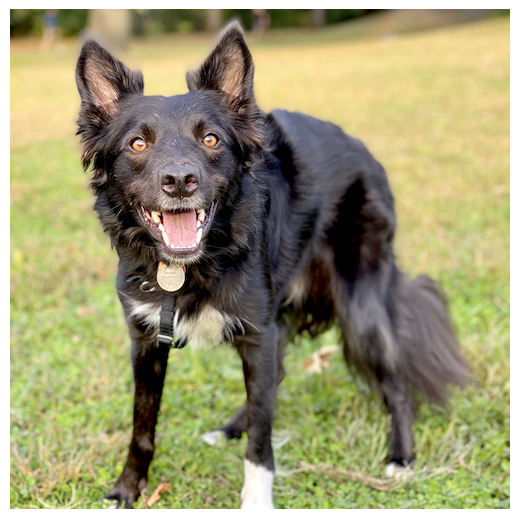

In [24]:
# For fun
sns.dogplot()